In [71]:
import os
import warnings
from functools import lru_cache

# Third-party
import astropy.units as u
import numpy as np
# from astropy.constants import c, h
# from astropy.convolution import Gaussian1DKernel, convolve
# from astropy.coordinates import Distance, SkyCoord
from astropy.io import fits
from astropy.time import Time
# from astroquery import log as asqlog
from astroquery.gaia import Gaia
# from astroquery.ipac.nexsci.nasa_exoplanet_archive import NasaExoplanetArchive
from copy import copy
import matplotlib.pyplot as plt

import warnings
from copy import deepcopy
from astropy.coordinates import Distance, SkyCoord, match_coordinates_sky
from astropy.wcs import WCS
from scipy import sparse
# from tqdm import tqdm


In [72]:
import utils

In [73]:
# We'll use this for apertures
def gaussian_2d(x, y, mu_x, mu_y, sigma_x=2, sigma_y=2):
    """
    Compute the value of a 2D Gaussian function.

    Parameters:
    x (float): x-coordinate.
    y (float): y-coordinate.
    mu_x (float): Mean of the Gaussian in the x-direction.
    mu_y (float): Mean of the Gaussian in the y-direction.
    sigma_x (float): Standard deviation of the Gaussian in the x-direction.
    sigma_y (float): Standard deviation of the Gaussian in the y-direction.

    Returns:
    float: Value of the 2D Gaussian function at (x, y).
    """
    part1 = 1 / (2 * np.pi * sigma_x * sigma_y)
    part2 = np.exp(
        -((x - mu_x) ** 2 / (2 * sigma_x**2) + (y - mu_y) ** 2 / (2 * sigma_y**2))
    )
    return part1 * part2

def dgaussian_2d(x, y, mu_x, mu_y, sigma_x=2, sigma_y=2):
    """
    Compute the value of a 2D Gaussian function. (This returns the amplitude you need to multiply by a Gaussian to get the actual gradient.)

    Parameters:
    x (float): x-coordinate.
    y (float): y-coordinate.
    mu_x (float): Mean of the Gaussian in the x-direction.
    mu_y (float): Mean of the Gaussian in the y-direction.
    sigma_x (float): Standard deviation of the Gaussian in the x-direction.
    sigma_y (float): Standard deviation of the Gaussian in the y-direction.

    """
    
    dG_x = -(x - mu_x)/sigma_x**2
    dG_y = -(y - mu_y)/sigma_y**2
    return dG_x, dG_y

class SparseWarp3D(sparse.coo_matrix):
    """Special class for working with stacks of sparse 3D images"""

    def __init__(self, data, row, col, imshape):
        if not np.all([row.ndim == 3, col.ndim == 3, data.ndim == 3]):
            raise ValueError("Pass a 3D array (nrow, ncol, nvecs)")
        self.nvecs = data.shape[-1]
        if not np.all(
            [
                row.shape[-1] == self.nvecs,
                col.shape[-1] == self.nvecs,
            ]
        ):
            raise ValueError("Must have the same 3rd dimension (nvecs).")
        self.subrow = row.astype(int)
        self.subcol = col.astype(int)
        self.subdepth = (
            np.arange(row.shape[-1], dtype=int)[None, None, :]
            * np.ones(row.shape, dtype=int)[:, :, None]
        )
        self.subdata = data
        self._kz = self.subdata != 0

        self.imshape = imshape
        self.subshape = row.shape
        self.cooshape = (np.prod([*self.imshape[:2]]), self.nvecs)
        self.coord = (0, 0)
        super().__init__(self.cooshape)
        index0 = (np.vstack(self.subrow)) * self.imshape[1] + (np.vstack(self.subcol))
        index1 = np.vstack(self.subdepth).ravel()
        self._index_no_offset = np.vstack([index0.ravel(), index1.ravel()])
        self._submask_no_offset = np.vstack(self._get_submask(offset=(0, 0))).ravel()
        self._subrow_v = deepcopy(np.vstack(self.subrow).ravel())
        self._subcol_v = deepcopy(np.vstack(self.subcol).ravel())
        self._subdata_v = deepcopy(np.vstack(deepcopy(self.subdata)).ravel())
        self._index1 = np.vstack(self.subdepth).ravel()

        self._set_data()

    def __add__(self, other):
        if isinstance(other, SparseWarp3D):
            data = deepcopy(self.subdata + other.subdata)
            if (
                (self.subcol != other.subcol)
                | (self.subrow != other.subrow)
                | (self.imshape != other.imshape)
                | (self.subshape != other.subshape)
            ):
                raise ValueError("Must have same base indicies.")
            return SparseWarp3D(
                data=data, row=self.subrow, col=self.subcol, imshape=self.imshape
            )
        else:
            return super(sparse.coo_matrix, self).__add__(other)

    def tocoo(self):
        return sparse.coo_matrix((self.data, (self.row, self.col)), shape=self.cooshape)

    def index(self, offset=(0, 0)):
        """Get the 2D positions of the data"""
        if offset == (0, 0):
            return self._index_no_offset
        index0 = (self._subrow_v + offset[0]) * self.imshape[1] + (
            self._subcol_v + offset[1]
        )
        return index0, self._index1

    def _get_submask(self, offset=(0, 0)):
        # find where the data is within the array bounds
        kr = ((self.subrow + offset[0]) < self.imshape[0]) & (
            (self.subrow + offset[0]) >= 0
        )
        kc = ((self.subcol + offset[1]) < self.imshape[1]) & (
            (self.subcol + offset[1]) >= 0
        )
        return kr & kc & self._kz

    def _set_data(self, offset=(0, 0)):
        if offset == (0, 0):
            index0, index1 = self.index((0, 0))
            self.row, self.col = (
                index0[self._submask_no_offset],
                index1[self._submask_no_offset],
            )
            self.data = self._subdata_v[self._submask_no_offset]
        else:
            # find where the data is within the array bounds
            k = self._get_submask(offset=offset)
            k = np.vstack(k).ravel()
            new_row, new_col = self.index(offset=offset)
            self.row, self.col = new_row[k], new_col[k]
            self.data = self._subdata_v[k]
        self.coord = offset

    def __repr__(self):
        return (
            f"<{(*self.imshape, self.nvecs)} SparseWarp3D array of type {self.dtype}>"
        )

    def dot(self, other):
        if other.ndim == 1:
            other = other[:, None]
        nt = other.shape[1]
        return super().dot(other).reshape((*self.imshape, nt)).transpose([2, 0, 1])

    def reset(self):
        """Reset any translation back to the original data"""
        self._set_data(offset=(0, 0))
        self.coord = (0, 0)
        return

    def clear(self):
        """Clear data in the array"""
        self.data = np.asarray([])
        self.row = np.asarray([])
        self.col = np.asarray([])
        self.coord = (0, 0)
        return

    def translate(self, position):
        """Translate the data in the array by `position` in (row, column)"""
        self.reset()
        # If translating to (0, 0), do nothing
        if position == (0, 0):
            return
        self.clear()
        self._set_data(position)
        return

In [74]:
@lru_cache()
def _query_gaia(query_str):
    job = Gaia.launch_job_async(query_str, verbose=False)
    tbl = job.get_results()
    return deepcopy(tbl)

In [75]:
def get_sky_catalog(
    ra=210.8023,
    dec=54.349,
    radius=0.155,
    grpmagnitude_range=(-3, 20),
    epoch=Time.now(),
    limit=None,
    gaia_keys=[
        "source_id",
        "ra",
        "dec",
        "parallax",
        "pmra",
        "pmdec",
        "radial_velocity",
        "ruwe",
        "phot_rp_mean_flux",
        "teff_gspphot",
        "logg_gspphot",
    ],
):
    """Gets a catalog of coordinates on the sky based on an input ra, dec and radius"""

    query_str = f"""
    SELECT {f'TOP {limit} ' if limit is not None else ''}* FROM (
        SELECT gaia.{', gaia.'.join(gaia_keys)}, dr2.teff_val AS dr2_teff_val,
        dr2.rv_template_logg AS dr2_logg, tmass.j_m, tmass.j_msigcom, tmass.ph_qual, DISTANCE(
        POINT({u.Quantity(ra, u.deg).value}, {u.Quantity(dec, u.deg).value}),
        POINT(gaia.ra, gaia.dec)) AS ang_sep,
        EPOCH_PROP_POS(gaia.ra, gaia.dec, gaia.parallax, gaia.pmra, gaia.pmdec,
        gaia.radial_velocity, gaia.ref_epoch, 2000) AS propagated_position_vector
        FROM gaiadr3.gaia_source AS gaia
        JOIN gaiadr3.tmass_psc_xsc_best_neighbour AS xmatch USING (source_id)
        JOIN gaiadr3.dr2_neighbourhood AS xmatch2 ON gaia.source_id = xmatch2.dr3_source_id
        JOIN gaiadr2.gaia_source AS dr2 ON xmatch2.dr2_source_id = dr2.source_id
        JOIN gaiadr3.tmass_psc_xsc_join AS xjoin USING (clean_tmass_psc_xsc_oid)
        JOIN gaiadr1.tmass_original_valid AS tmass ON
        xjoin.original_psc_source_id = tmass.designation
        WHERE 1 = CONTAINS(
        POINT({u.Quantity(ra, u.deg).value}, {u.Quantity(dec, u.deg).value}),
        CIRCLE(gaia.ra, gaia.dec, {(u.Quantity(radius, u.deg) + 50*u.arcsecond).value}))
        AND gaia.parallax IS NOT NULL
        AND gaia.phot_rp_mean_mag > {grpmagnitude_range[0]}
        AND gaia.phot_rp_mean_mag < {grpmagnitude_range[1]}) AS subquery
    WHERE 1 = CONTAINS(
    POINT({u.Quantity(ra, u.deg).value}, {u.Quantity(dec, u.deg).value}),
    CIRCLE(COORD1(subquery.propagated_position_vector), COORD2(subquery.propagated_position_vector), {u.Quantity(radius, u.deg).value}))
    ORDER BY ang_sep ASC
    """
    tbl = _query_gaia(query_str)
    if len(tbl) == 0:
        raise ValueError("Could not find matches.")

    tbl = tbl.to_pandas()
    k = (~np.isfinite(tbl["parallax"])) | (tbl["parallax"] < 0)
    tbl.loc[k, "parallax"] = 0
    k = ~np.isfinite(tbl["logg_gspphot"])
    tbl.loc[k, "logg_gspphot"] = tbl["dr2_logg"][k]
    k = ~np.isfinite(tbl["teff_gspphot"])
    tbl.loc[k, "teff_gspphot"] = tbl["dr2_teff_val"][k]
    k = ~np.isfinite(tbl["ruwe"])
    tbl.loc[k, "ruwe"] = 99
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        c = SkyCoord(
            ra=tbl["ra"] * u.deg,
            dec=tbl["dec"] * u.deg,
            pm_ra_cosdec=np.nan_to_num(tbl["pmra"]) * u.mas / u.year,
            pm_dec=np.nan_to_num(tbl["pmdec"]) * u.mas / u.year,
            obstime=Time.strptime("2016", "%Y"),
            distance=Distance(
                parallax=np.asarray(tbl["parallax"]) * u.mas, allow_negative=True
            ),
            radial_velocity=np.nan_to_num(tbl["radial_velocity"]) * u.km / u.s,
        ).apply_space_motion(epoch)
        tbl["RA_EPOCH"] = c.ra.deg
        tbl["DEC_EPOCH"] = c.dec.deg
    return tbl

In [98]:
# make a function to read in TESS FFIs

# next to do: unpack Ben's fits files and play around with them
hdulist = fits.open(
    # "/Users/chedges/Downloads/ffis/tess2022363171841-s0060-1-3-0249-s_ffic.fits"
    "./data/tess2022329190202-s0058-1-2-0247-s_ffic.fits"
    # "./data/ben_example_ffis.fits"
    # "./data/ben_example_rois.fits"
)
wcs = WCS(hdulist[1].header)

Set MJD-END to 59908.800157 from DATE-END'. [astropy.wcs.wcs]


In [115]:
import lightkurve as lk

ra = hdulist[1].header['CRVAL1']
dec = hdulist[1].header['CRVAL2']
c = SkyCoord(ra, dec, unit='deg')


temp = lk.TessTargetPixelFile.from_fits_images(images_flux=["./data/tess2022329190202-s0058-1-2-0247-s_ffic.fits"],
                                        position=SkyCoord(ra, dec, unit='deg'),
                                        size=(200,201),
                                        target_id='MyCutOut')

Set MJD-END to 59908.800157 from DATE-END'. [astropy.wcs.wcs]
100%|██████████| 1/1 [00:00<00:00, 11.81it/s]


In [118]:
# temp1 = temp.to_fits(output_fn=)
# temp.hdu[1].header
hdulist[1].header


XTENSION= 'IMAGE   '           / marks the beginning of a new HDU               
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / NAXIS                                          
NAXIS1  =                 2136 / length of first array dimension                
NAXIS2  =                 2078 / length of second array dimension               
PCOUNT  =                    0 / group parameter count (not used)               
GCOUNT  =                    1 / group count (not used)                         
INHERIT =                    T / inherit the primary header                     
EXTNAME = 'CAMERA.CCD 1.2 cal' / name of extension                              
EXTVER  =                    1 / extension version number (not format version)  
SIMDATA =                    F / file is based on simulated data                
TELESCOP= 'TESS    '           / telescope                                      
INSTRUME= 'TESS Photometer' 

In [147]:
# hdulist[1].data[cutout].shape
# hdulist[1].data[cutout[0][0]:cutout[0][1], cutout[1][0]:cutout[1][1]].shape
# R, C = np.mgrid[cutout[0][0]:cutout[0][1], cutout[1][0]:cutout[1][1]]
# hdulist[1].data[R, C].shape
# plt.imshow(hdulist[1].data[R, C])
# plt.imshow(hdulist[1].data[cutout[0][0]:cutout[0][1], cutout[1][0]:cutout[1][1]])

hdulist[2].header

XTENSION= 'IMAGE   '           / marks the beginning of a new HDU               
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / NAXIS                                          
NAXIS1  =                 2136 / length of first array dimension                
NAXIS2  =                 2078 / length of second array dimension               
PCOUNT  =                    0 / group parameter count (not used)               
GCOUNT  =                    1 / group count (not used)                         
INHERIT =                    T / inherit the primary header                     
EXTNAME = 'CAMERA.CCD 1.2 uncert' / name of extension                           
EXTVER  =                    1 / extension version number (not format version)  
SIMDATA =                    F / file is based on simulated data                
TELESCOP= 'TESS    '           / telescope                                      
INSTRUME= 'TESS Photometer' 

In [148]:
def clip_TESS_fits(hdulist, cutout):
    """"""
    # make a output file
    output = hdulist.copy()

    # caclulate new pixel grid
    R, C = np.mgrid[cutout[0][0]:cutout[0][1], cutout[1][0]:cutout[1][1]]
    R0, C0 = R[:, 0].mean(), C[0].mean()

    # cut out the data
    output[1].data = hdulist[1].data[R, C]
    output[2].data = hdulist[2].data[R, C]

    # make a wcs
    wcs = WCS(hdulist[1].header)
    c = wcs.pixel_to_world(R0, C0)
    ra0, dec0 = c.ra.deg, c.dec.deg

    # update header values
    output[1].header['NAXIS1'] = cutout[0][1] - cutout[0][0]
    output[1].header['NAXIS2'] = cutout[1][1] - cutout[1][0]
    output[1].header['CRPIX1'] = R0
    output[1].header['CRPIX2'] = C0
    output[1].header['CRVAL1'] = ra0
    output[1].header['CRVAL2'] = dec0
    output[2].header['NAXIS1'] = cutout[0][1] - cutout[0][0]
    output[2].header['NAXIS2'] = cutout[1][1] - cutout[1][0]
    output[2].header['CRPIX1'] = R0
    output[2].header['CRPIX2'] = C0
    output[2].header['CRVAL1'] = ra0
    output[2].header['CRVAL2'] = dec0
    
    return output



In [151]:
output = clip_TESS_fits(hdulist, [[200,400], [200,301]])

Set MJD-END to 59908.800157 from DATE-END'. [astropy.wcs.wcs]


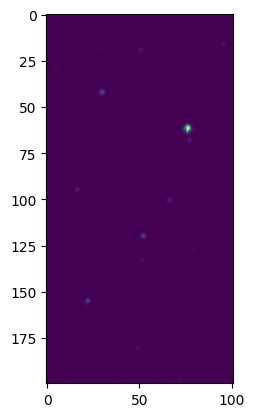

In [152]:
plt.imshow(output[1].data)

In [128]:
print(R[:, 0].mean())
print((R[-1, 0] + R[0, 0])/2)
print(np.mean(cutout[0]))

299.5
299.5
300.0


In [85]:
# make a function for reading TESS FFIs
def read_TESS_fits(hdulist, cutout=None):
    if cutout is None:
        # later, double check that you have the axes aligned properly
        cutout = [[0, hdulist[1].header['NAXIS1']], [0, hdulist[1].header['NAXIS2']]]
    ...


cutout=[[100,500],[200,501]]

# use a cutout of a tess FFI
R, C = np.mgrid[cutout[0][0]:cutout[0][1], cutout[1][0]:cutout[1][1]]
image_shape = R.shape
R0, C0 = R[:, 0].mean(), C[0].mean()
wR, wC = R - R0, C - C0
data = hdulist[1].data[cutout[0][0]:cutout[0][1], cutout[1][0]:cutout[1][1]]
err = hdulist[2].data[cutout[0][0]:cutout[0][1], cutout[1][0]:cutout[1][1]]

# make a wcs
wcs = WCS(hdulist[1].header)
c = wcs.pixel_to_world(R0, C0)
ra0, dec0 = c.ra.deg, c.dec.deg
l = np.asarray([[0, 0], [0, -1], [-1, 0], [-1, -1]]).T
cs = wcs.pixel_to_world(R[l[0], l[1]], C[l[0], l[1]])
radius = np.max(c.separation(cs).deg)
df = get_sky_catalog(
    ra0,
    dec0,
    radius=radius,
    grpmagnitude_range=(-3, 16),
    gaia_keys=[
        "source_id",
        "ra",
        "dec",
        "parallax",
        "pmra",
        "pmdec",
        "radial_velocity",
        "ruwe",
        "phot_rp_mean_flux",
        "teff_gspphot",
        "logg_gspphot",
        "phot_g_mean_flux", 
        "phot_g_mean_mag",
    ],
    epoch=Time(hdulist[0].header["DATE-OBS"]),
)

INFO: Query finished. [astroquery.utils.tap.core]


## Reading in Ben Fits Files (not working rn)

In [79]:
# read in TESSfile
hdulist = fits.open(
    # "/Users/chedges/Downloads/ffis/tess2022363171841-s0060-1-3-0249-s_ffic.fits"
    # "./data/tess2022329190202-s0058-1-2-0247-s_ffic.fits"
    # "./data/ben_example_ffis.fits"
    # "./data/ben_example_rois.fits"
)
wcs = WCS(hdulist[1].header)

In [80]:
# make a function for reading Ben's FFIs
def read_fits(hdulist, cutout=None):
    if cutout is None:
        # later, double check that you have the axes aligned properly
        cutout = [[0, hdulist[1].header['NAXIS1']], [0, hdulist[1].header['NAXIS2']]]
    ...


cutout=[[100,500],[200,501]]
hdulist = fits.open(
    # "/Users/chedges/Downloads/ffis/tess2022363171841-s0060-1-3-0249-s_ffic.fits"
    # "./data/tess2022329190202-s0058-1-2-0247-s_ffic.fits"
    "./data/ben_example_ffis.fits"
    # "./data/ben_example_rois.fits"
)
wcs = WCS(hdulist[1].header)

# use a cutout of a tess FFI
R, C = np.mgrid[cutout[0][0]:cutout[0][1], cutout[1][0]:cutout[1][1]]
image_shape = R.shape
R0, C0 = R[:, 0].mean(), C[0].mean()
wR, wC = R - R0, C - C0
data = hdulist[1].data[0, cutout[0][0]:cutout[0][1], cutout[1][0]:cutout[1][1]]
err = 1/13*np.sqrt(data)  # for now, this is a reasonable approximation of the errors from TESS

# make a wcs
# wcs = WCS(hdulist[1].header)

# Create a new WCS object.  The number of axes must be set
# from the start
wcs = WCS(naxis=2)

# Set up an "Airy's zenithal" projection
# Vector properties may be set with Python lists, or Numpy arrays
wcs.wcs.crpix = [R0, C0]
wcs.wcs.cdelt = np.array([-0.066667, 0.066667])
wcs.wcs.crval = [0, -90]
wcs.wcs.ctype = ["RA---AIR", "DEC--AIR"]
wcs.wcs.set_pv([(2, 1, 45.0)])

c = wcs.pixel_to_world(R0, C0, 0)
ra0, dec0 = c.ra.deg, c.dec.deg
l = np.asarray([[0, 0], [0, -1], [-1, 0], [-1, -1]]).T
cs = wcs.pixel_to_world(R[l[0], l[1]], C[l[0], l[1]])
radius = np.max(c.separation(cs).deg)
df = get_sky_catalog(
    ra0,
    dec0,
    radius=radius,
    grpmagnitude_range=(-3, 16),
    gaia_keys=[
        "source_id",
        "ra",
        "dec",
        "parallax",
        "pmra",
        "pmdec",
        "radial_velocity",
        "ruwe",
        "phot_rp_mean_flux",
        "teff_gspphot",
        "logg_gspphot",
        "phot_g_mean_flux", 
        "phot_g_mean_mag",
    ],
    epoch=Time(hdulist[0].header["DATE-OBS"]),
)

IndexError: list index out of range

In [70]:
hdulist[1].data.shape
hdulist[0].header#['TARG_RA']
hdulist[1].header


XTENSION= 'IMAGE   '           / marks the beginning of a new HDU               
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / NAXIS                                          
NAXIS1  =                 2136 / length of first array dimension                
NAXIS2  =                 2078 / length of second array dimension               
PCOUNT  =                    0 / group parameter count (not used)               
GCOUNT  =                    1 / group count (not used)                         
INHERIT =                    T / inherit the primary header                     
EXTNAME = 'CAMERA.CCD 1.2 cal' / name of extension                              
EXTVER  =                    1 / extension version number (not format version)  
SIMDATA =                    F / file is based on simulated data                
TELESCOP= 'TESS    '           / telescope                                      
INSTRUME= 'TESS Photometer' 

In [46]:
cutout=[[100,500],[200,501]]
cutout[0][1]

500

In [62]:
# wcs.pixel_to_world(R0, C0)
R0
wcs

WCS Keywords

Number of WCS axes: 3
CTYPE : ''  ''  ''  
CRVAL : 0.0  0.0  0.0  
CRPIX : 0.0  0.0  0.0  
PC1_1 PC1_2 PC1_3  : 1.0  0.0  0.0  
PC2_1 PC2_2 PC2_3  : 0.0  1.0  0.0  
PC3_1 PC3_2 PC3_3  : 0.0  0.0  1.0  
CDELT : 1.0  1.0  1.0  
NAXIS : 2048  2048  1

In [57]:
# make a function for reading Ben's FFIs
def read_fits(hdulist, cutout=None):
    if cutout is None:
        # later, double check that you have the axes aligned properly
        cutout = [[0, hdulist[1].header['NAXIS1']], [0, hdulist[1].header['NAXIS2']]]
    ...


cutout=[[100,500],[200,501]]
hdulist = fits.open(
    # "/Users/chedges/Downloads/ffis/tess2022363171841-s0060-1-3-0249-s_ffic.fits"
    # "./data/tess2022329190202-s0058-1-2-0247-s_ffic.fits"
    "./data/ben_example_ffis.fits"
    # "./data/ben_example_rois.fits"
)
wcs = WCS(hdulist[1].header)

# use a cutout of a tess FFI
R, C = np.mgrid[cutout[0][0]:cutout[0][1], cutout[1][0]:cutout[1][1]]
image_shape = R.shape
R0, C0 = R[:, 0].mean(), C[0].mean()
wR, wC = R - R0, C - C0
data = hdulist[1].data[0, cutout[0][0]:cutout[0][1], cutout[1][0]:cutout[1][1]]
err = 1/13*np.sqrt(data)  # for now, this is a reasonable approximation of the errors from TESS

# make a wcs
# wcs = WCS(hdulist[1].header)

# Create a new WCS object.  The number of axes must be set
# from the start
wcs = WCS(naxis=2)

# Set up an "Airy's zenithal" projection
# Vector properties may be set with Python lists, or Numpy arrays
wcs.wcs.crpix = [R0, C0]
wcs.wcs.cdelt = np.array([-0.066667, 0.066667])
wcs.wcs.crval = [0, -90]
wcs.wcs.ctype = ["RA---AIR", "DEC--AIR"]
wcs.wcs.set_pv([(2, 1, 45.0)])

c = wcs.pixel_to_world(R0, C0, 0)
ra0, dec0 = c.ra.deg, c.dec.deg
l = np.asarray([[0, 0], [0, -1], [-1, 0], [-1, -1]]).T
cs = wcs.pixel_to_world(R[l[0], l[1]], C[l[0], l[1]])
radius = np.max(c.separation(cs).deg)
df = get_sky_catalog(
    ra0,
    dec0,
    radius=radius,
    grpmagnitude_range=(-3, 16),
    gaia_keys=[
        "source_id",
        "ra",
        "dec",
        "parallax",
        "pmra",
        "pmdec",
        "radial_velocity",
        "ruwe",
        "phot_rp_mean_flux",
        "teff_gspphot",
        "logg_gspphot",
        "phot_g_mean_flux", 
        "phot_g_mean_mag",
    ],
    epoch=Time(hdulist[0].header["DATE-OBS"]),
)

AttributeError: 'list' object has no attribute 'ra'

In [22]:
# use a cutout of a tess FFI
R, C = np.mgrid[1500:1700, 1501:1700]
image_shape = R.shape
R0, C0 = R[:, 0].mean(), C[0].mean()
wR, wC = R - R0, C - C0
data = hdulist[1].data[0, 1500:1700, 1501:1700]
# err = hdulist[2].data[1500:1700, 1501:1700]

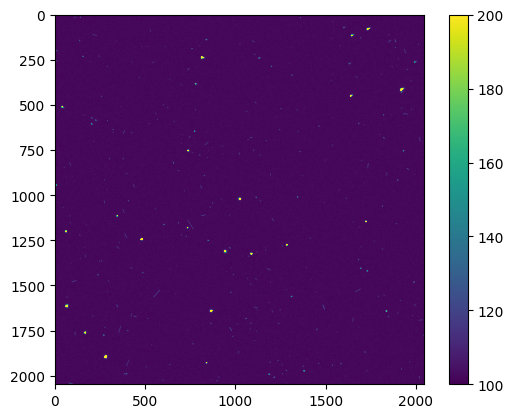

In [34]:
plt.imshow(hdulist[1].data[0,:,:], vmin=100, vmax=200)
plt.colorbar()

In [ ]:




# make a wcs
c = wcs.pixel_to_world(R0, C0)
ra0, dec0 = c.ra.deg, c.dec.deg
l = np.asarray([[0, 0], [0, -1], [-1, 0], [-1, -1]]).T
cs = wcs.pixel_to_world(R[l[0], l[1]], C[l[0], l[1]])
radius = np.max(c.separation(cs).deg)
df = get_sky_catalog(
    ra0,
    dec0,
    radius=radius,
    grpmagnitude_range=(-3, 16),
    gaia_keys=[
        "source_id",
        "ra",
        "dec",
        "parallax",
        "pmra",
        "pmdec",
        "radial_velocity",
        "ruwe",
        "phot_rp_mean_flux",
        "teff_gspphot",
        "logg_gspphot",
        "phot_g_mean_flux", 
        "phot_g_mean_mag",
    ],
    epoch=Time(hdulist[0].header["DATE-OBS"]),
)

# I bet this "round" step is the culprit for why the weights look weird later
# instead, we should keep a rounded and an unrounded version
df[["X", "Y"]] = np.asarray(
    wcs.world_to_pixel(SkyCoord(df["RA_EPOCH"], df["DEC_EPOCH"], unit="deg"))
).T
df[["X0", "Y0"]] = np.round(np.asarray(
    wcs.world_to_pixel(SkyCoord(df["RA_EPOCH"], df["DEC_EPOCH"], unit="deg"))
).T, 2)

# this looks like it's taking a 3 pixel buffer around the image
k = (
    (df.X0 > R[0, 0] - 3)
    & (df.X0 < R[-1, 0] + 3)
    & (df.Y0 > C[0, 0] - 3)
    & (df.Y0 < C[0, -1] + 3)
)
df = df[k]
df = df.sort_values('phot_rp_mean_flux')
df = df.drop_duplicates(['X0', 'Y0'], keep='first')
df = df.reset_index(drop=True)

# subtract out a polynomial background
k = data.ravel() < np.percentile(data, 20)
polyorder = 2
poly = np.vstack(
    [
        wR.ravel() ** idx * wC.ravel() ** jdx
        for idx in range(polyorder + 1)
        for jdx in range(polyorder + 1)
    ]
).T
bkg_model = poly.dot(
    np.linalg.solve(poly[k].T.dot(poly[k]), poly[k].T.dot(data.ravel()[k]))
).reshape(data.shape)
data -= bkg_model